In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from sklearn.neural_network import MLPRegressor
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
url = 'http://apmonitor.com/pds/uploads/Main/wind.txt'
data = pd.read_csv(url)
data.head()

,Time,Direction,Speed,Power
0,2018-01-01 00:00,259.994904,5.311336,380.047791
1,2018-01-01 00:10,268.641113,5.672167,453.769196
2,2018-01-01 00:20,272.564789,5.216037,306.376587
3,2018-01-01 00:30,271.258087,5.659674,419.645904
4,2018-01-01 00:40,265.674286,5.577941,380.650696


In [3]:
Future = []
for i in range(len(data['Power'])):
    if i<len(data['Power'])-1:
        Future.append(data['Power'][i+1])
    else:
        Future.append(data['Power'][i])

data['Future'] = Future

In [4]:
data.describe()

,Direction,Speed,Power,Future
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,123.687559,7.557952,1307.684332,1307.732628
std,93.443736,4.227166,1312.459242,1312.470008
min,0.000000,0.000000,-2.471405,-2.471405
25%,49.315437,4.201395,50.677890,50.677890
50%,73.712978,7.104594,825.838074,825.944366
75%,201.696720,10.300020,2482.507568,2482.528992
max,359.997589,25.206011,3618.732910,3618.732910


## Data Cleansing

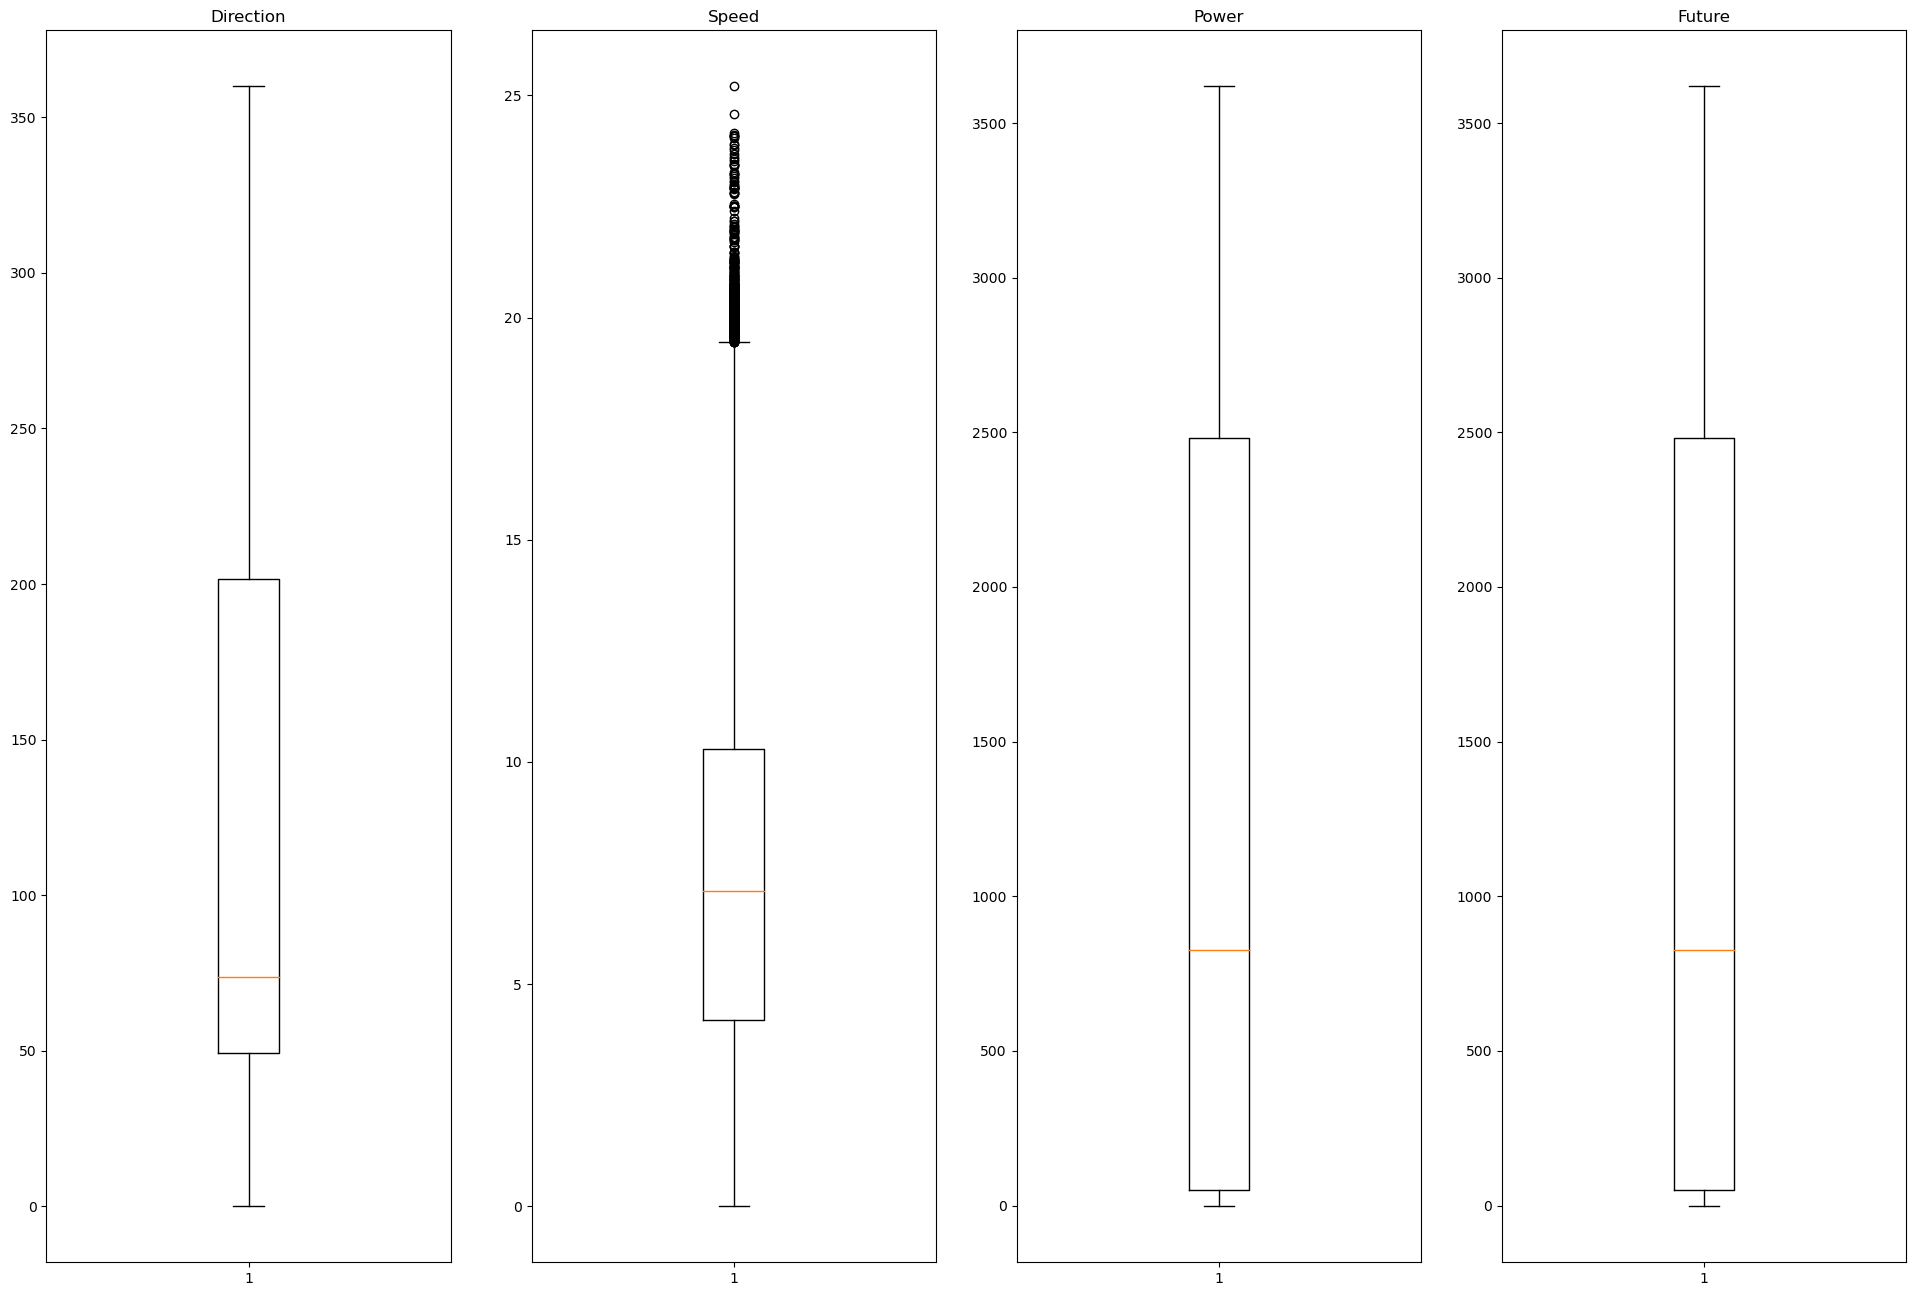

In [5]:
features = ['Direction', 'Speed', 'Power', 'Future']
%matplotlib inline
plt.figure(figsize=(24,16))
for i,c in enumerate(features):
    plt.subplot(1,4,i+1)
    plt.title(str(c))
    plt.boxplot(data[c])
plt.show()

In [6]:
data = data[data['Speed']<22]
data = data[data['Power']>0]
data = data[data['Future']>0]
data = data[data['Power']<3600]
data = data[data['Future']<3600]

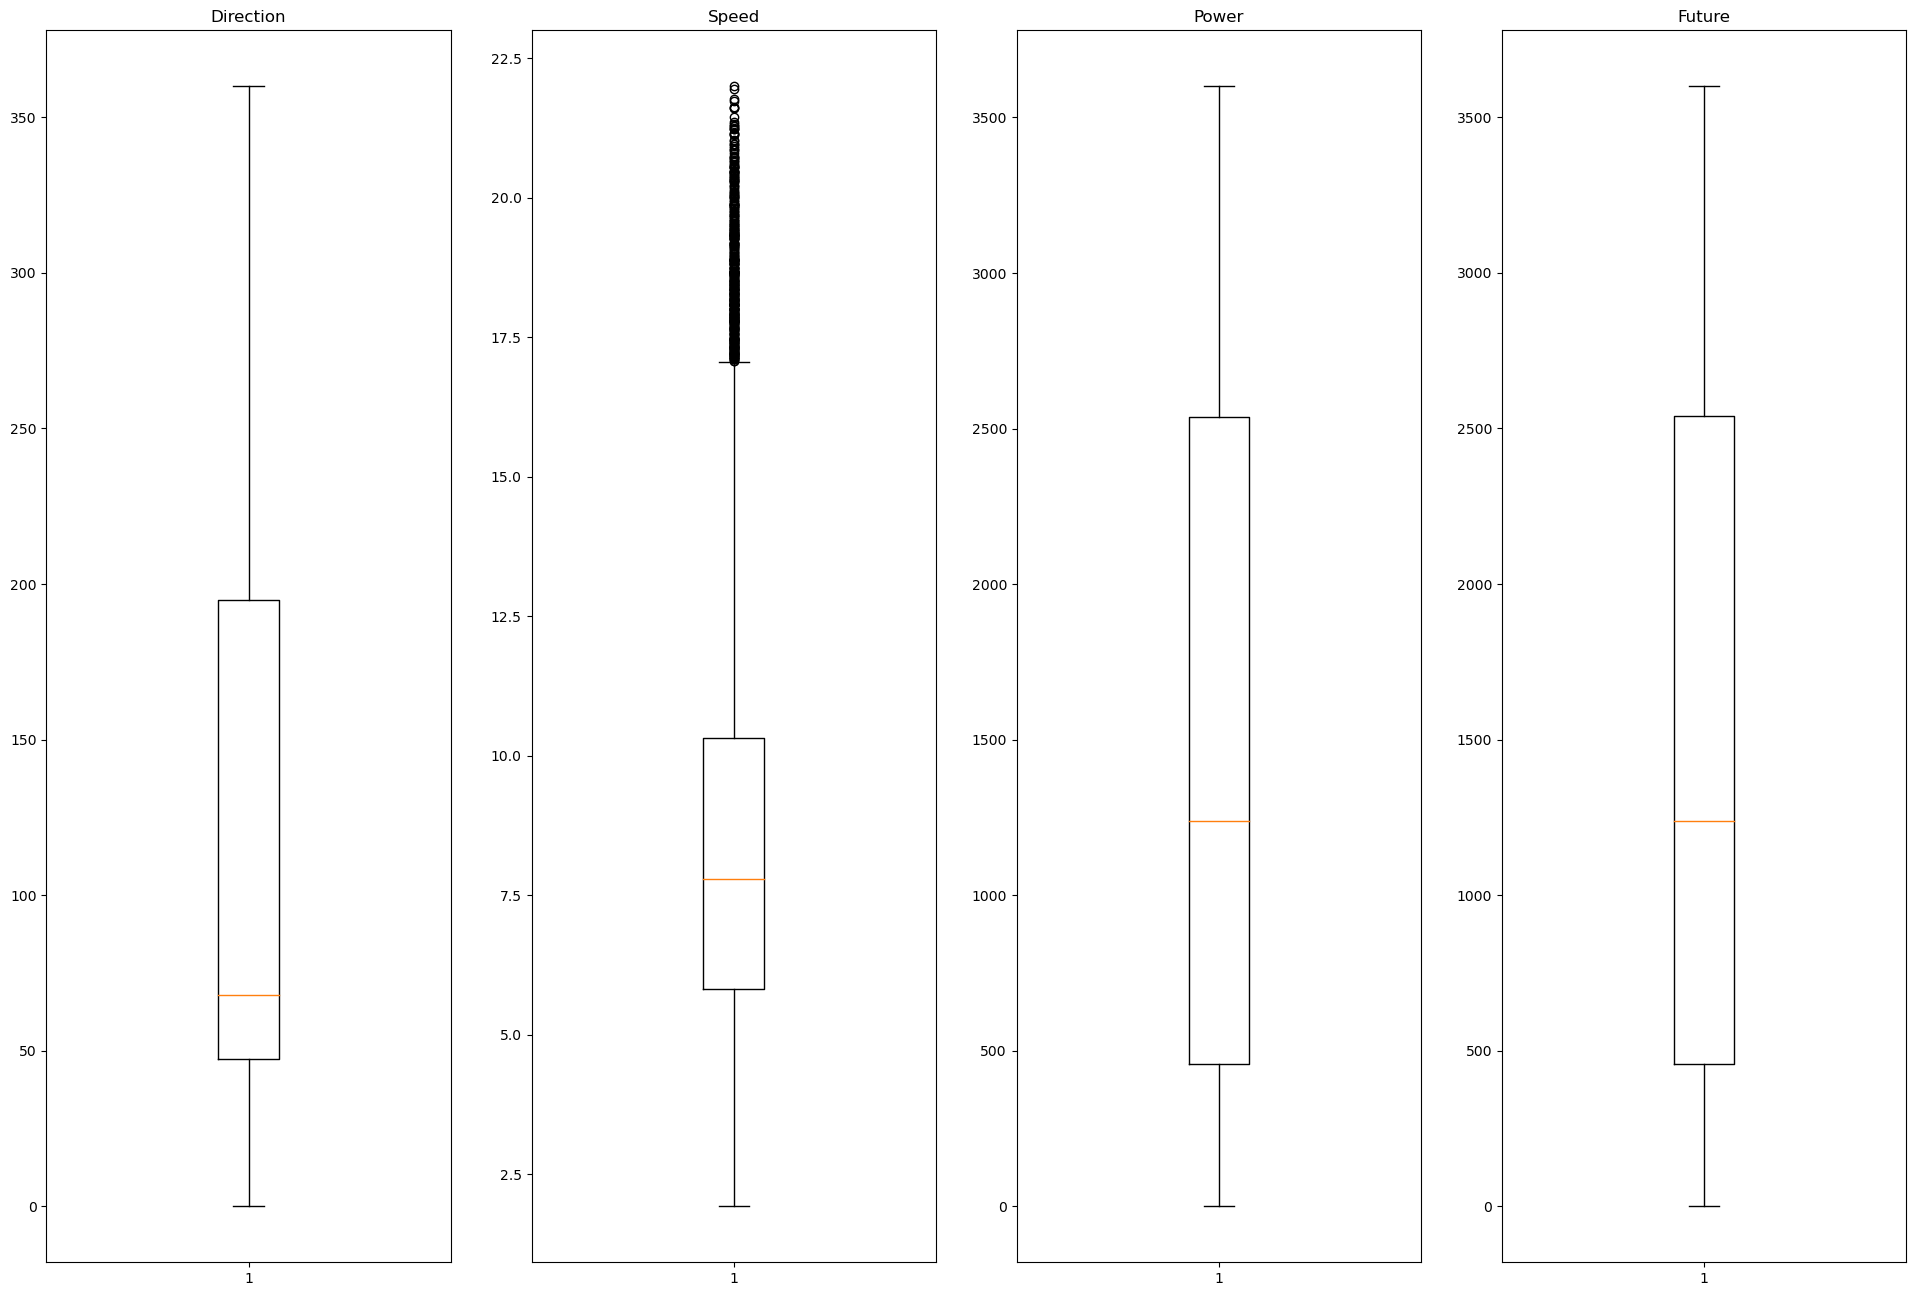

In [7]:
plt.figure(figsize=(24,16))
for i,c in enumerate(features):
    plt.subplot(1,4,i+1)
    plt.title(str(c))
    plt.boxplot(data[c])
plt.show()

In [8]:
data.describe()

,Direction,Speed,Power,Future
count,35671.000000,35671.000000,35671.000000,35671.000000
mean,111.015579,8.194584,1515.351905,1514.728154
std,86.324026,3.094431,1165.865552,1166.708718
min,0.000000,1.929033,0.034533,0.000200
25%,47.215546,5.828761,458.240204,458.011551
50%,67.966553,7.791436,1236.838013,1237.066040
75%,194.843948,10.323730,2538.449951,2538.659546
max,359.997589,21.995440,3599.997070,3599.995117


<AxesSubplot:>

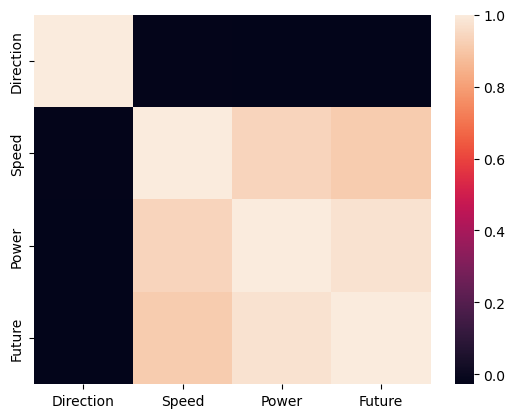

In [9]:
sns.heatmap(data.corr())

## Data Scaling

In [10]:
data = data[features]

In [11]:
# Scale
s = StandardScaler()
data_s = s.fit_transform(data)
data_s = pd.DataFrame(data_s, columns = data.columns)

# Split data into X and y
features = ['Direction', 'Speed', 'Power']
X = data_s[features]
y = data_s['Future']

# Each input uses last 'window' number
window = 6
X_lstm = []
y_lstm = []
for i in range(window,len(data_s)):
    X_lstm.append(X[i-window:i])
    y_lstm.append(y[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

<AxesSubplot:xlabel='Features'>

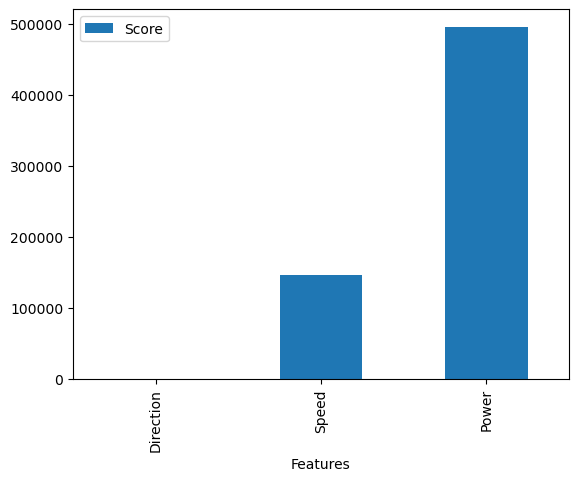

In [12]:
skb = SelectKBest(f_regression,k='all')
fit = skb.fit(X_train,y_train)
scores = pd.DataFrame({'Features':X_train.columns,'Score':fit.scores_})
scores = scores.set_index('Features',drop=True)
scores.plot(kind='bar')

The most important features to predict the wind power in 10 minutes in order are the 10 minute prior wind power, speed, and direction.

## Regression

In [13]:
xgbr = xgb.XGBRegressor()
nn = MLPRegressor(max_iter=10000)

# Initialize LSTM model
lstm = Sequential()
lstm.add(LSTM(units=75, return_sequences=True, input_shape=(X_lstm.shape[1],X_lstm.shape[2])))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=75))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))
lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

regress = [[xgbr,'XGBoost'],
           [nn,'Neural Network']]

for method, name in regress:
    method.fit(X_train,y_train)

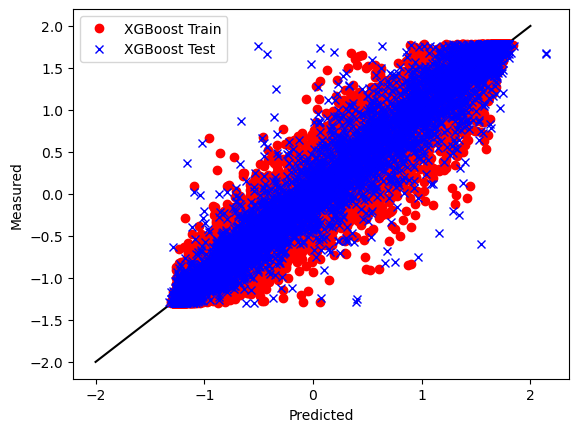

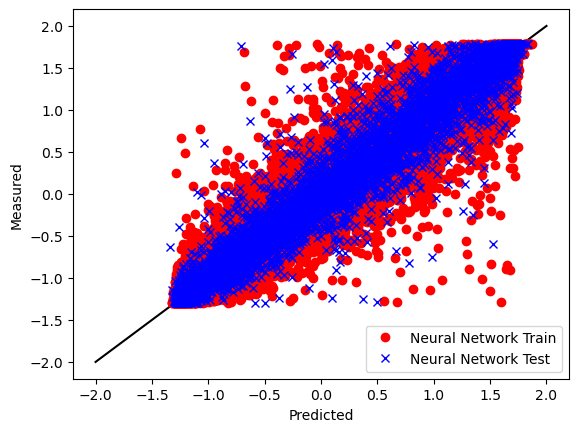

In [14]:
for method,name in regress:
    plt.figure()
    plt.plot([-2,2],[-2,2],'k-')
    plt.plot(method.predict(X_train),y_train,'ro',label=name+' Train')
    plt.plot(method.predict(X_test),y_test,'bx',label=name+' Test')
    plt.xlabel('Predicted')
    plt.ylabel('Measured')
    plt.legend()

In [15]:
for method,name in regress:
    train_mae = np.absolute(cross_val_score(method, X_train, y_train, scoring='neg_mean_absolute_error'))
    test_mae = np.absolute(cross_val_score(method, X_test, y_test, scoring='neg_mean_absolute_error'))
    print(name+'Train MAE is {:.4f}'.format(train_mae.mean()))
    print(name+'Test MAE is {:.4f}'.format(test_mae.mean()))

XGBoostTrain MAE is 0.1540
XGBoostTest MAE is 0.1587
Neural NetworkTrain MAE is 0.1511
Neural NetworkTest MAE is 0.1503


In [16]:
for method,name in regress:
    train = method.predict(X_train)
    r2 = r2_score(y_train,train)
    print(name+'Train R2 is {:.3f}'.format(r2))
    
    test = method.predict(X_test)
    r2 = r2_score(y_test,test)
    print(name+'Test R2 is {:.3f}'.format(r2))

XGBoostTrain R2 is 0.963
XGBoostTest R2 is 0.945
Neural NetworkTrain R2 is 0.946
Neural NetworkTest R2 is 0.947


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
286/286 [==============================] - 8s 16ms/step - loss: 0.1712 - val_loss: 0.1268
Epoch 2/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1174 - val_loss: 0.1158
Epoch 3/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1086 - val_loss: 0.1051
Epoch 4/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1053 - val_loss: 0.1044
Epoch 5/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1040 - val_loss: 0.1035
Epoch 6/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1043 - val_loss: 0.1044
Epoch 7/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1039 - val_loss: 0.1031
Epoch 8/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1040 - val_loss: 0.1058
Epoch 9/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1031 - val_loss: 0.1030
Epoch 10/50
286/286 [==============================] - 4s 13ms/step - loss: 0.1035 - val_lo

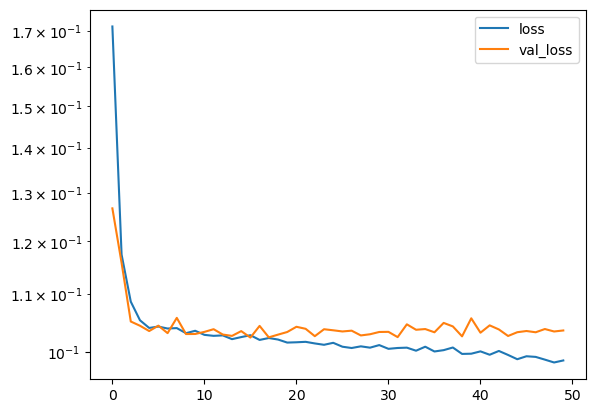

In [17]:
        # Fit LSTM model
history = lstm.fit(X_lstm, y_lstm, verbose=1, validation_split=0.2,
            callbacks = [TqdmCallback(verbose=1)],#es
            batch_size=100,
            epochs=50)

# Plot loss and save model
epochs = es.stopped_epoch
plt.semilogy(history.history['loss'],label='loss')
plt.semilogy(history.history['val_loss'],label='val_loss')
plt.legend()

lstm.save('lstm.h5')

In [18]:
print('LSTM Train MAE is {:.6f}'.format(history.history['loss'][-1]))
print('LSTM Test MAE is {:.6f}'.format(history.history['val_loss'][-1]))

LSTM Train MAE is 0.098581
LSTM Test MAE is 0.103589
